# Notes

This was used to sample data for Phase 2 of the annotation process by finding "conversation-like" comments from Reddit that were also rated as controversial by Reddit users. The latter condition was used to hopefully find more comments that elicit contextual inappropriateness, but the annotators ultimately decide those.

In [1]:
import pandas as pd
#import datasets
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification,Trainer, TrainingArguments
import torch.nn as nn
import torch
from datasets import Dataset, DatasetDict
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import wandb
import os
from collections import Counter
import evaluate
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer


os.environ["WANDB_DISABLED"] = "true"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # replace the 0 with other gpu ids
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Load in the dataset for recognizing Conversational comments
(See paper for details)

In [2]:
directory = '/shared/2/projects/contextual-appropriateness/data/conversational/'

In [3]:
train_df = pd.read_csv(directory+'train_data_all.tsv',sep = '\t').dropna()
dev_df = pd.read_csv(directory+'dev_data.tsv',sep='\t').dropna()
len(train_df), len(dev_df)

(593710, 74212)

In [4]:
train_df.label = train_df.label.apply(int)
dev_df.label = dev_df.label.apply(int)
train_df.head()

,text,label,origin
0,They do not!,1,movies
1,They do to!,1,movies
2,I hope so.,1,movies
3,She okay?,1,movies
4,Let's go.,1,movies


In [5]:
Counter(train_df.label)

Counter({1: 296856, 0: 296854})

In [6]:
Counter(train_df.origin)

Counter({'movies': 225907, 'empathetic-dialog': 70949, 'reddit': 296854})

In [7]:
Counter(dev_df.origin)

Counter({'movies': 28238, 'empathetic-dialog': 8868, 'reddit': 37106})

In [8]:
len(dev_df)

74212

In [8]:
tds = Dataset.from_pandas(train_df)
vds = Dataset.from_pandas(dev_df)

ds = DatasetDict()

ds['train'] = tds
ds['validation'] = vds
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'origin', '__index_level_0__'],
        num_rows: 593710
    })
    validation: Dataset({
        features: ['text', 'label', 'origin', '__index_level_0__'],
        num_rows: 74212
    })
})

In [9]:
ds['validation'][0]

{'text': " I'm here.  That's all that counts. Watch... you'll enjoy this... it's like magic...",
 'label': 1,
 'origin': 'movies',
 '__index_level_0__': 0}

In [11]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased")

In [12]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)

In [13]:
tokenized_ds = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/593710 [00:00<?, ? examples/s]

Map:   0%|          | 0/74212 [00:00<?, ? examples/s]

In [14]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
output_dir = '/shared/2/projects/contextual-appropriateness/models/conversational/'

model = AutoModelForSequenceClassification.from_pretrained("microsoft/MiniLM-L12-H384-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    learning_rate=2e-5,
    per_device_train_batch_size=72,
    per_device_eval_batch_size=128,
    num_train_epochs=1,
    weight_decay=0.01,
    do_eval=True,
    bf16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.310400
1000,0.218300
1500,0.203800
2000,0.198400
2500,0.191200
3000,0.183200
3500,0.188300
4000,0.181200
4500,0.177600
5000,0.172700


In [25]:
trainer.evaluate()

{'eval_loss': 0.16270506381988525,
 'eval_runtime': 67.0883,
 'eval_samples_per_second': 1106.185,
 'eval_steps_per_second': 8.645,
 'epoch': 1.0}

In [26]:
dev_logits = trainer.predict(tokenized_ds["validation"])

In [25]:
dev_logits = dev_preds

In [26]:
print(dev_logits.predictions.shape, dev_logits.label_ids.shape)

(74212, 2) (74212,)


In [27]:
dev_preds = np.argmax(dev_logits.predictions, axis=-1)

In [32]:
dev_preds

array([1, 1, 1, ..., 0, 0, 0])

In [42]:
#metric = evaluate.load("precision", "recall", "f1")
print(evaluate.load("precision").compute(predictions=dev_preds, references=tokenized_ds["validation"]['label']))
print(evaluate.load("recall").compute(predictions=dev_preds, references=tokenized_ds["validation"]['label']))
print(evaluate.load("f1").compute(predictions=dev_preds, references=tokenized_ds["validation"]['label']))

{'precision': 0.9236298058074802}
{'recall': 0.9523796690562173}
{'f1': 0.9377844414664243}


# Load in controversial data

In [ ]:
import glob

In [ ]:
cdir = '/shared/2/projects/contextual-appropriateness/data/controversial-reddit-comments/'
controversial_files = glob.glob(cdir + '*.tsv')
len(controversial_files)

In [ ]:
controversial_files

In [28]:
col_names = ['text', 'reddit_id']

In [ ]:
c_dfs = []
for fname in tqdm(controversial_files):
    df = pd.read_csv(fname,  names=col_names, header=None, sep='\t')
    c_dfs.append(df)

In [50]:
c_dfs[0].head()

,text,reddit_id
0,Most Americans don't want their president to f...,dy8ok3c
1,Stop will ya . I am invested in switcheo and w...,dy8ok4r
2,The divide and conquer narrative has no place ...,dy8ok5w
3,particularly since the two other look like chi...,dy8ok73
4,The disgusting cunt that somehow ended the “im...,dy8ok82


In [67]:
cdfs = None

In [29]:
target_fname = '/shared/2/projects/contextual-appropriateness/data/controversial-reddit-comments/RC_2018-02.tsv'
controversial_df = pd.read_csv(target_fname,  names=col_names, header=None, sep='\t').dropna()
len(controversial_df)

1917334

In [30]:
#controversial_df = None #pd.concat(c_dfs).dropna()

In [31]:
len(controversial_df.dropna())

1917334

### There were _way_ too many controversial comments to label, so just sample 10% since we won't be annotating all of them anyway

In [41]:
sample = controversial_df.sample(frac=0.1)

In [42]:
cds = Dataset.from_pandas(sample)

In [43]:
len(cds)

191733

In [44]:
tokenized_cds = cds.map(preprocess_function, batched=True)

Map:   0%|          | 0/191733 [00:00<?, ? examples/s]

In [45]:
type(tokenized_cds)

datasets.arrow_dataset.Dataset

In [46]:
cds_logits = trainer.predict(tokenized_cds)

In [50]:
import math
def sigmoid(x):
    return 1 / (1 + math.exp(-x))
sigmoid_v = np.vectorize(sigmoid)

In [51]:
conv_probs = sigmoid_v(cds_logits[0][:][:,1])

In [64]:
import seaborn as sns

In [66]:
#sns.displot(conv_probs)

In [ ]:
cds_logits[0][3]

In [82]:
torch.sigmoid

<function torch._VariableFunctionsClass.sigmoid>

In [86]:
cds_conv_preds = np.argmax(cds_logits.predictions, axis=-1)

In [87]:
len(cds_conv_preds)

1917346

In [88]:
cds_conv_preds[0:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [92]:
len(controversial_df)

1917346

In [53]:
sample['conversational_prob'] = conv_probs

<AxesSubplot:>

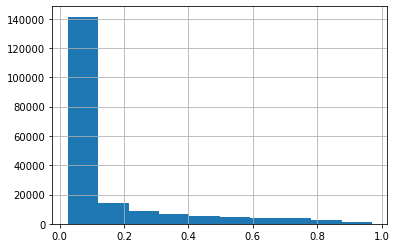

In [68]:
sample['conversational_prob'].hist()

In [54]:
example_df = sample.sort_values(by='conversational_prob')

In [60]:
example_df.head()

,text,reddit_id,conversational_prob
378931,&gt;Gnar buffs\n\nY tho,dtu8ti5,0.025179
1831868,SCAM.\nhttps://www.reddit.com/user/cairadacb,dux6ety,0.025179
169232,&gt; subtly\n\n:/,dtoj8dw,0.025179
57187,&gt; everytime\n\n*every time,dtlcrac,0.025179
1145408,bleep bloop [in russian bot language] fuck u ...,duetlog,0.025179


In [59]:
for row in example_df.sample(50).sort_values(by='conversational_prob').itertuples():
    print('%0.2f\t%s' % (row.conversational_prob, row.text))

0.03	Can I get an upvote for Norwegian Jazz Metal?\nhttps://youtu.be/iGwBp7Yr0Oo
0.03	Ewwwwww.\n\n\nThe game looks so much  better in 1.3.\n\n\nThe lack of Godrays, lack of color correction, weak shadows,and no HBAO really makes the game look bland and washed out in 1.03\n\nThe game is absolutely stunning even on Ps4 atm.........\n\nSo\n\nMan I can't wait to see what 1.5 adds!\n\n\nBoth visuals wise and gameplay wise.  :)
0.03	Wickd thinks he is still somehow relevant, just watch his twitch bio LUL, never seen someone with &lt; 1k viwers be so full of himself 
0.03	Fuck these refs lol. I’m done. See you in the tourney penn state 
0.03	This post inspired me to unsubscribe. While D2 was awful, this post made me realize i didn't need all the stupid negative posts coming up as I browse Reddit. Would recommend the rest of you do as well and just try again when D3 comes out.
0.03	[deleted]
0.03	You mean one is *also* a GPS and you're trying to tell me that makes it a *totally different objec

In [125]:
controversial_df.head(10)

,text,reddit_id,conversational_prob
0,"&gt;By the way, I trust police officers, perha...",dtjoj5t,0.008872
1,If only he abused male children a different way.,dtjoj60,0.034740
2,It's not too long until the summer muppetry st...,dtjoj6l,0.053784
3,&gt;Apple ~~broke my stuff~~ has given me a gr...,dtjoj84,0.008848
4,"Hello Mr Sid :"")",dtjoj86,0.023017
5,"I didn't used to dislike atheists, but on-line...",dtjoj8x,0.008751
6,Looks like they took a page out of the Dem's b...,dtjojbb,0.898020
7,1. Santa Clara Vanguard\n\n2. Blue Devils\n\n3...,dtjojcm,0.008849
8,Like definitely not the best thing to do but i...,dtjojd6,0.020905
9,Jerry will let Morris walk and put All Day beh...,dtjojeq,0.011099


In [126]:
conv_cont_df = controversial_df[controversial_df.conversational_prob > 0.5]
len(conv_cont_df)

145210

In [127]:
conv_cont_df.head()

,text,reddit_id,conversational_prob
6,Looks like they took a page out of the Dem's b...,dtjojbb,0.898020
40,Fuck that. Jerry is a pest. Do you want some d...,dtjoki3,0.985815
69,Could it perhaps be the thumbnail of a black w...,dtjolrw,0.900478
93,Let's hope he retires all his political aspira...,dtjomik,0.855261
111,He was a hard guy to root for.,dtjoncj,0.868311


In [2]:
cdir = '/shared/2/projects/contextual-appropriateness/data/controversial-reddit-comments/'

In [129]:
conv_cont_df.to_csv(cdir + 'conversation-controversial-comments.RC_2018-02.csv', index=False)

In [130]:
conv_cont_df.head(20)

,text,reddit_id,conversational_prob
6,Looks like they took a page out of the Dem's b...,dtjojbb,0.898020
40,Fuck that. Jerry is a pest. Do you want some d...,dtjoki3,0.985815
69,Could it perhaps be the thumbnail of a black w...,dtjolrw,0.900478
93,Let's hope he retires all his political aspira...,dtjomik,0.855261
111,He was a hard guy to root for.,dtjoncj,0.868311
127,Why assume they were left in the dark?,dtjoobj,0.924102
145,The food is pretty terrible but it's a fun pla...,dtjop0s,0.961251
155,Nice Honda!,dtjopjt,0.877390
163,What's your reason for thinking this?,dtjoq4w,0.932074
167,But they have the high ground.,dtjoq8d,0.927620


In [3]:
conv_cont_df = pd.read_csv(cdir + 'conversation-controversial-comments.RC_2018-02.csv')

In [4]:
sdf = conv_cont_df.sort_values(by='conversational_prob')

In [11]:
sdf.head()

,text,reddit_id,conversational_prob
17426,Thanks for the assumption.,dtq3omh,0.500597
52981,Hi body language and attitude is atrocious. We...,du30eug,0.500716
113078,"Oh, so you do have that experience. You're a h...",duo8hty,0.500778
107193,Haha I agree.,dum6ot7,0.500782
35425,She wants to have her cake and eat it too. A ...,dtwnedb,0.501157


In [9]:
for t in sdf.text.head():
    print(t)

Thanks for the assumption.
Hi body language and attitude is atrocious. We should dump him.
Oh, so you do have that experience. You're a homosexual alcoholic. I wouldn't wish that on anyone. Who are they harming, themselves. Homosexuality is a disorder that results in corruption of the soul and also the inability to procreate. 
Haha I agree.
She wants to have her cake and eat it too.  A piece of land is an investment. A car is a depreciating asset. Even if you throw aside the deal you made, buying land is a far better investment.


In [10]:
sdf.tail()

,text,reddit_id,conversational_prob
15,"Come over to classical, folks. You can spend a...",dtjotj1,0.989505
78330,This man speaks truth. Just this morning I was...,dubyvys,0.989511
56840,Wondering why Salvador kiks arse? I see your p...,du4di6b,0.989512
104862,"No, you fool. With your skinny arms --- pretze...",dulebvz,0.989512
96,"You callin' me pal, chief? Huh?? Who you cal...",dtjpxoy,0.989513


In [ ]:
for t in sdf.text.tail():
    print(t)